In [ ]:
"""
                         Politécnico de Leiria
       Licenciatura Engenharia Eletrotécnica e de Computadores
                        Projeto Final de Curso
                                Dem4AI


Autores:  Francisco António Lisboa Guarda   Nº2201675
          Samuel Domingos Lourenço          Nº2200904


Orientadores: Luís Manuel Conde Bento
              Mónica Jorge Carvalho de Figueiredo


"""

 **Este código faz parte do** [AI for Beginners Curricula](http://github.com/microsoft/ai-for-beginners). Foi alterado de forma a adaptar o nosso exemplo.

---
$\hspace{0.2cm}*********Explicação\hspace{0.2cm}do\hspace{0.2cm}codigo*********$
---
---

Chamar as bibliotecas

In [25]:
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os
import gzip

# escolha a semente para reprodutibilidade - altere-a para explorar os efeitos de variações aleatórias
np.random.seed(1)
import random

**Classificação das frutas**

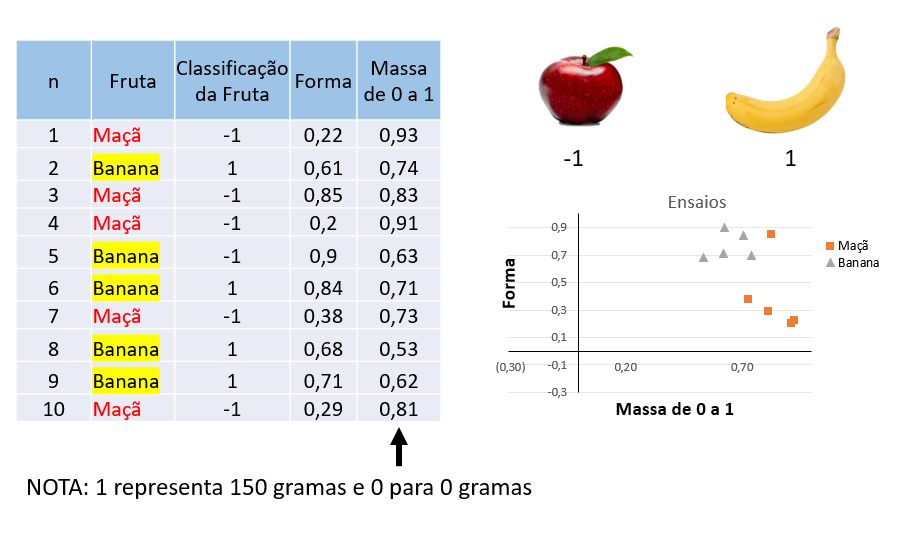

Definimos o valor de 'n' como o número de amostras (neste caso, é o número de frutas).
\
Criamos dois arrays: o array 'X', onde serão guardadas as características das frutas (massa e forma), e o array 'Y', que representa a classificação das frutas. O valor 1 corresponde a bananas e o valor -1 corresponde a maçãs.

\

Dividimos os dados em dois conjuntos: um conjunto de treino e outro de testes.

In [26]:
n = 10
X = np.array( [[0.93,0.22], [0.74,0.61], [0.83,0.85], [0.91,0.2], [0.63,0.9], [0.71,0.84], [0.73, 0.38], [0.53,0.68], [0.62,0.71], [0.81,0.29]] )
Y = np.array( [[-1], [1], [-1], [-1], [1], [1], [-1], [1], [1], [-1] ] )

# Divida em dois conjuntos um de treino e o outro de teste
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])
print("Array de Treino:\n")
print("Características:\n",train_x[0:10])
print("classificação:\n",train_labels[0:10])
print("\nArray de Teste:\n")
print("Características:\n",test_x[0:10])
print("classificação:\n",test_labels[0:10])

Array de Treino:

Características:
 [[0.93 0.22]
 [0.74 0.61]
 [0.83 0.85]
 [0.91 0.2 ]
 [0.63 0.9 ]
 [0.71 0.84]
 [0.73 0.38]
 [0.53 0.68]]
classificação:
 [[-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]]

Array de Teste:

Características:
 [[0.62 0.71]
 [0.81 0.29]]
classificação:
 [[ 1]
 [-1]]


Este código cria um gráfico usando um conjunto de dados de treino (array treino) representado os pontos vermelhos (negativos) são representados como "maçãs" e os pontos azuis (positivos) são representados como "bananas".

\

O gráfico ajuda a entender como essas informações estão relacionadas em duas características diferentes.

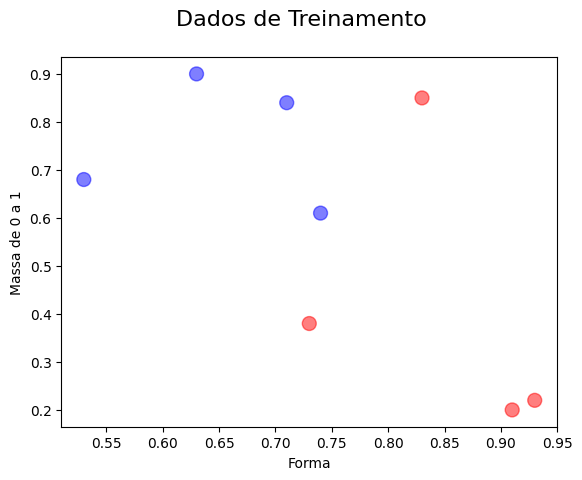

In [27]:
def plot_dataset(suptitle, features, labels):

    # Preparar o gráfico
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('Forma')
    ax.set_ylabel('Massa de 0 a 1')

    # Criar uma lista de cores para as frutas
    colors = ['r' if l == -1 else 'b' for l in labels]
    # Desenhar os pontos das frutas
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    # Mostrar o gráfico
    fig.show()

# Chamar a função para desenhar o gráfico com as frutas
plot_dataset('Dados de Treinamento', train_x, train_labels)

## Perceptron


O perceptron é um tipo de classificador binário que decide se uma entrada pertence a uma classe ou outra. Ele utiliza um vetor de pesos $\mathbf{w}$ e uma função de ativação degrau $f$ para calcular a saída $y(\mathbf{x})$.

**Formula:**
$$y(\mathbf{x}) = f(\mathbf{w}^{\mathrm{T}}\mathbf{x})$$

Se o resultado do produto interno entre $\mathbf{w}$ e o vetor de entrada $\mathbf{x}$ for maior ou igual a zero, a saída é +1; caso contrário, é -1.

$$
f(x) = \begin{cases}
         +1 & x \geq 0 \\
         -1 & x < 0
       \end{cases} \\
$$

Para simplificar o modelo, podemos introduzir uma dimensão adicional às características de entrada, cujo valor é sempre 1. Isso nos permite eliminar o termo de viés $\mathbf{b}$ na equação, facilitando os cálculos. O perceptron é uma base fundamental para entender conceitos mais complexos de aprendizado de máquina e redes neurais.

In [28]:
pos_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x)
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x)
                          if train_labels[i]<0])
print(pos_examples[0:10])
print(neg_examples[0:10])

[[0.74 0.61 1.  ]
 [0.63 0.9  1.  ]
 [0.71 0.84 1.  ]
 [0.53 0.68 1.  ]]
[[0.93 0.22 1.  ]
 [0.83 0.85 1.  ]
 [0.91 0.2  1.  ]
 [0.73 0.38 1.  ]]


Para treinar o perceptron, precisamos encontrar os pesos $\mathbf{w}$ que minimizarão o erro. O erro é definido usando o critério do perceptron:

$$E(\mathbf{w}) = -\sum_{n \in \mathcal{M}}\mathbf{w}^{\mathrm{T}}\mathbf{x}_{n}t_{n}$$

* $t_{n} \in \{-1, +1\}$ para exemplos de treinamento negativos e positivos, respectivamente.
* $\mathcal{M}$ - um conjunto de exemplos classificados incorretamente.

Utilizaremos o processo de descida do gradiente. Começando com alguns pesos iniciais aleatórios $\mathbf{w}^{(0)}$, ajustaremos os pesos em cada etapa do treinamento usando o gradiente de $E$:

$$\mathbf{w}^{\tau + 1}=\mathbf{w}^{\tau} - \eta \nabla E(\mathbf{w}) = \mathbf{w}^{\tau} + \eta \mathbf{x}_{n} t_{n}$$


onde $\eta$ é a taxa de aprendizado e $\tau \in \mathbb{N}$ é o número de iterações.

Vamos definir esse algoritmo em Python:

In [29]:
def train_all(positive_examples, negative_examples, num_iterations = 1000):
    num_dims = positive_examples.shape[1]
    print(num_dims)

    # Initialize weights.
    # We initialize with 0 for simplicity, but random initialization is also a good idea
    weights = np.zeros((num_dims,1))

    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    print(pos_count)
    print(neg_count)

    report_frequency = 10
    learning_rate=1;

    for i in range(num_iterations):
       for j in range(pos_count):
          # Pick one positive and one negative example

          pos = positive_examples[j]
          neg = negative_examples[j]
          z = np.dot(pos, weights)

          if z < 0: # positive example was classified as negative
              weights = weights + learning_rate*pos.reshape(weights.shape)

          z  = np.dot(neg, weights)
          if z >= 0: # negative example was classified as positive
              weights = weights - learning_rate * neg.reshape(weights.shape)

          # Periodically, print out the current accuracy on all examples
          if i % report_frequency == 0:
              if learning_rate > 0.01:
                learning_rate= learning_rate/10
              pos_out = np.dot(positive_examples, weights)
              neg_out = np.dot(negative_examples, weights)
              pos_correct = (pos_out >= 0).sum() / float(pos_count)
              neg_correct = (neg_out < 0).sum() / float(neg_count)
              print("Iteration={}, learning_rate={}, pos correct={}, neg correct={}".format(i,learning_rate,pos_correct,neg_correct))
              print("weights={}".format(weights.transpose()))
          if pos_correct == 1 and  neg_correct == 1:
            print("Iteration={}, learning_rate={}, pos correct={}, neg correct={}".format(i,learning_rate,pos_correct,neg_correct))
            print("weights={}".format(weights.transpose()))
            return weights

    return weights
    wts = train_all(pos_examples,neg_examples)


In [30]:
# print(wts.transpose())

Como pode observar, a precisão inicial é de cerca de 50%, mas rapidamente aumenta para valores mais elevados próximos de 90%.

Vamos visualizar como as classes estão separadas. A nossa função de classificação é representada por $\mathbf{w}^Tx$ e é maior do que 0 para uma classe e menor do que 0 para outra. Assim, a linha de separação das classes é definida por $\mathbf{w}^Tx = 0$. Uma vez que temos apenas duas dimensões $x_0$ e $x_1$, a equação para a linha seria $w_0x_0+w_1x_1+w_2 = 0$ (lembre-se de que definimos explicitamente uma dimensão extra $x_2=1$). Vamos representar esta linha graficamente:

In [31]:
def plot_boundary(positive_examples, negative_examples, weights):
    # Verifica se o peso da segunda dimensão está próximo de zero
    if np.isclose(weights[1], 0):
        # Se o peso da primeira dimensão também estiver próximo de zero
        if np.isclose(weights[0], 0):
            # Define valores de x e y para criar uma linha diagonal
            x = y = np.array([-6, 6], dtype='float32')
        else:
            # Define valores de y para criar uma linha horizontal
            y = np.array([-6, 6], dtype='float32')
            # Calcula valores de x para a linha de separação usando a equação da reta
            x = -(weights[1] * y + weights[2]) / weights[0]
    else:
        # Define valores de x para criar uma linha vertical
        x = np.array([-6, 6], dtype='float32')
        # Calcula valores de y para a linha de separação usando a equação da reta
        y = -(weights[0] * x + weights[2]) / weights[1]

    # Define os limites dos eixos x e y no gráfico
    pylab.xlim(0, 1)
    pylab.ylim(-1, 1)

    pylab.xlim(0, 1)
    pylab.ylim(-1, 1)
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)

    # Exibe o gráfico
    pylab.show()


In [33]:
#plot_boundary(pos_examples,neg_examples,wts)

## Avaliação no Conjunto de Teste

No início, reservamos alguns dados para o conjunto de teste. Vamos ver quão precisa é a nossa classificação nesse conjunto de teste. Para fazer isso, também expandimos o conjunto de teste com uma dimensão extra, multiplicamos pela matriz de pesos e garantimos que o valor obtido tenha o mesmo sinal que a etiqueta (+1 ou -1). Em seguida, somamos todos os valores booleanos e dividimos pelo tamanho da amostra de teste para obter a precisão:

In [32]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

#accuracy(wts, test_x, test_labels)

## Observando o Processo de Treinamento

Já vimos anteriormente como a precisão diminui durante o treinamento. Seria interessante ver como a linha de separação se comporta durante o treinamento. O código abaixo irá visualizar tudo em um gráfico, e você deve ser capaz de mover o controle deslizante para "viajar no tempo" através do processo de treinamento.

In [35]:
def train_all_graph(positive_examples, negative_examples, num_iterations = 1000):
    num_dims = positive_examples.shape[1]
    print(num_dims)

    # Initialize weights.
    # We initialize with 0 for simplicity, but random initialization is also a good idea
    weights = np.zeros((num_dims,1))

    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    print(pos_count)
    print(neg_count)

    report_frequency = 10
    learning_rate=1;

    snapshots = []

    for i in range(num_iterations):
       for j in range(pos_count):
          # Pick one positive and one negative example
          pos = positive_examples[j]
          neg = negative_examples[j]


          z = np.dot(pos, weights)
          if z < 0: # positive example was classified as negative
              weights = weights + learning_rate*pos.reshape(weights.shape)

          z  = np.dot(neg, weights)
          if z >= 0: # negative example was classified as positive
              weights = weights - learning_rate * neg.reshape(weights.shape)

          # Periodically, print out the current accuracy on all examples
          if i % report_frequency == 0:
              if learning_rate > 0.01:
                learning_rate= learning_rate/10
              pos_out = np.dot(positive_examples, weights)
              neg_out = np.dot(negative_examples, weights)
              pos_correct = (pos_out >= 0).sum() / float(pos_count)
              neg_correct = (neg_out < 0).sum() / float(neg_count)
              print("Iteration={}, learning_rate={}, pos correct={}, neg correct={}".format(i,learning_rate,pos_correct,neg_correct))
              print("weights={}".format(weights.transpose()))
              snapshots.append((np.copy(weights),(pos_correct+neg_correct)/2.0))

          if pos_correct == 1 and  neg_correct == 1:
            print("Iteration={}, learning_rate={}, pos correct={}, neg correct={}".format(i,learning_rate,pos_correct,neg_correct))
            print("weights={}".format(weights.transpose()))
            snapshots.append((np.copy(weights),(pos_correct+neg_correct)/2.0))
            return np.array(snapshots)

    return np.array(snapshots)


snapshots = train_all_graph(pos_examples,neg_examples)

def plotit_all(pos_examples,neg_examples,snapshots,step):
    fig = pylab.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1)
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(snapshots[:,1])), snapshots[:,1])
    pylab.ylabel('Accuracy')
    pylab.xlabel('Iteration')
    pylab.plot(step, snapshots[step,1], "bo")
    pylab.show()
def pl1_all(step): plotit_all(pos_examples,neg_examples,snapshots,step)

3
4
4
Iteration=0, learning_rate=0.1, pos correct=0.0, neg correct=1.0
weights=[[-0.93 -0.22 -1.  ]]
Iteration=0, learning_rate=0.01, pos correct=0.0, neg correct=1.0
weights=[[-0.867 -0.13  -0.9  ]]
Iteration=0, learning_rate=0.01, pos correct=0.0, neg correct=1.0
weights=[[-0.8599 -0.1216 -0.89  ]]
Iteration=0, learning_rate=0.01, pos correct=0.0, neg correct=1.0
weights=[[-0.8546 -0.1148 -0.88  ]]
Iteration=10, learning_rate=0.01, pos correct=0.0, neg correct=1.0
weights=[[-0.6123  0.164  -0.51  ]]
Iteration=10, learning_rate=0.01, pos correct=0.0, neg correct=1.0
weights=[[-0.606  0.173 -0.5  ]]
Iteration=10, learning_rate=0.01, pos correct=0.0, neg correct=1.0
weights=[[-0.5989  0.1814 -0.49  ]]
Iteration=10, learning_rate=0.01, pos correct=0.0, neg correct=1.0
weights=[[-0.5936  0.1882 -0.48  ]]
Iteration=20, learning_rate=0.01, pos correct=0.75, neg correct=1.0
weights=[[-0.3576  0.458  -0.12  ]]
Iteration=20, learning_rate=0.01, pos correct=0.75, neg correct=1.0
weights=[[-0.35

<ipython-input-35-b0a4aefaeae8>:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(snapshots)


In [36]:
interact(pl1_all, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=109), Output()), _dom_classes=('widget-intera…

<function __main__.pl1_all(step)>